In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import scipy.io
import scipy.signal

In [2]:
index_files_path = 'SFootBD/IndexFiles/'
data_files_path = 'SFootBD/SFootBD/'

train_list_file = index_files_path + 'LstTrain'
imposter_list_file = index_files_path + 'LstImp'
test_evaluation_list_file = index_files_path + 'LstTestEvaluation'
test_validation_list_file = index_files_path + 'LstTestValidation'

In [3]:
train_list = pd.read_csv(train_list_file, sep = ' ', header = None)

train_list.head()

,0,1
0,15,2007-05-22_16-35-52_693
1,15,2007-05-22_16-24-39_584
2,15,2007-05-22_16-35-41_215
3,15,2007-05-22_16-24-29_028
4,15,2007-05-22_16-24-50_450


In [4]:
mat_file = os.path.join(data_files_path, train_list[1][0] + '.mat')

mat = scipy.io.loadmat(mat_file)

In [5]:
def foot_reshape(arr):
    # 88 + 3 zeros = 91 which is reshaped to 13 x 7
    arr = np.append(arr, np.zeros((arr.shape[0], 3)), axis = 1)
    
    return np.reshape(arr, (arr.shape[0], 13, 7))

def prepare_data(matrix):
    # Left footstep
    dataL = foot_reshape(mat['dataL'])
    # Right footstep
    dataR = foot_reshape(mat['dataR'])
    
    # Both left and right combined
    return np.append(dataL, dataR, axis = 2)

# Downsample using order 8 Chebyshev type I filter
def downsample(data):
    return scipy.signal.decimate(data, 6, axis = 0)

In [6]:
data = prepare_data(mat)

print data.shape

(2200L, 13L, 14L)


In [7]:
# After Tmax, the following signals don't contain data
Tmax = 1600

spatial = data[:Tmax]

# Accumulated Pressure gives spatial representation
spatial = np.add.accumulate(np.abs(spatial), axis = 0)
spatial = np.sum(spatial, axis = 0)

spatial.shape

(13L, 14L)

In [8]:
spatial_max = np.max(spatial)

# Scale to [0, 1]
spatial /= spatial_max

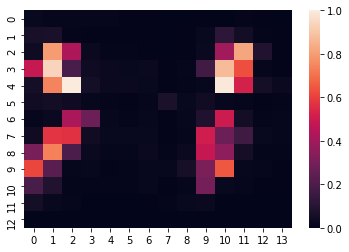

In [9]:
# Spatial representation
sns.heatmap(spatial)

C:\Users\Mathew\Anaconda2\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\Mathew\Anaconda2\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


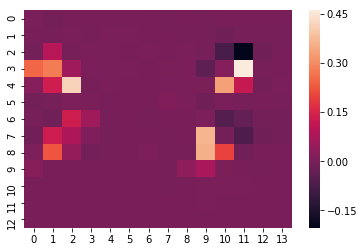

In [10]:
# Temporal Representation
# After downsampling take frames with 50 <= t < 150
temporal_frames = downsample(data)[50:150]

temporal_max = np.max(temporal_frames)

sns.heatmap(temporal_frames[0] / temporal_max)

C:\Users\Mathew\Anaconda2\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


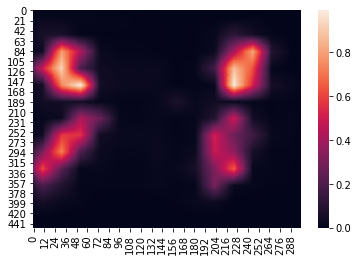

In [11]:
from skimage.transform import resize

# 45 mm x 30 mm
scaled_spatial_img = resize(spatial, (450, 300))

sns.heatmap(scaled_spatial_img)

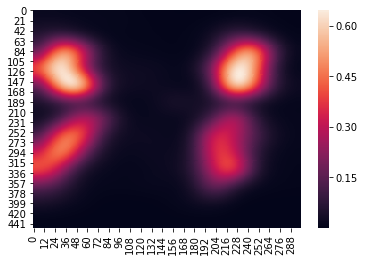

In [12]:
import scipy.ndimage

# Smoothening using Gaussian filter
processed_spatial = scipy.ndimage.gaussian_filter(scaled_spatial_img, sigma = 14)

sns.heatmap(processed_spatial)

# Now, rotate and align based on position with highest pressure value